In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#shuffle csv
from sklearn.utils import shuffle

#Multiprocessing
import multiprocessing
from tqdm import tqdm  # Barre de progression

#import feature
from src.phase_folding import create_folded_lightcurve

# TensorFlow
pr_auc = tf.keras.metrics.AUC(curve='PR', name='pr_auc')

print("Bibliothèques importées (avec multiprocessing et tqdm).")

Bibliothèques importées (avec multiprocessing et tqdm).


In [23]:
print("Chargement des données brutes...")
train_df = pd.read_csv('../data/raw/train.csv')

X_raw = train_df.drop('LABEL', axis=1).values
y = train_df['LABEL'].values - 1  # (0, 1)

print("Mélange des données...")
X_raw_shuffled, y_shuffled = shuffle(X_raw, y, random_state=42)

print(f"Forme de X_raw_shuffled : {X_raw_shuffled.shape}")
print(f"Forme de y_shuffled : {y_shuffled.shape}")

Chargement des données brutes...
Mélange des données...
Forme de X_raw_shuffled : (5087, 3197)
Forme de y_shuffled : (5087,)


In [24]:
N_BINS = 500

# On utilise les données complètes (mélangées) de la Cellule 2
X_data_to_process = X_raw_shuffled
y_data_to_process = y_shuffled

print(f"Démarrage du pré-traitement 'Phase Folding' PARALLÉLISÉ sur {len(X_data_to_process)} étoiles...")

# 1. Déterminer le nombre de cœurs
N_CORES = multiprocessing.cpu_count() - 1
if N_CORES < 1:
    N_CORES = 1
print(f"Utilisation de {N_CORES} cœurs CPU...")

# 2. Préparer les arguments pour la fonction
# (Notre fonction a besoin de 2 arguments : row et n_bins)
func_args = [(row, N_BINS) for row in X_data_to_process]

# 3. Créer un "pool" de workers et lancer le calcul
with multiprocessing.Pool(processes=N_CORES) as pool:
    # pool.starmap est fait pour les fonctions avec plusieurs arguments
    # tqdm ajoute la barre de progression
    X_folded = list(tqdm(pool.starmap(create_folded_lightcurve, func_args), total=len(X_data_to_process)))

# 4. Convertir la liste de résultats en array numpy
X_folded = np.array(X_folded)

# 5. y devient y_data_to_process pour la Cellule 4
y = y_data_to_process

print("Pré-traitement 'Phase Folding' terminé !")
print(f"Forme de X_folded (nos nouvelles features) : {X_folded.shape}")
print(f"Forme de y (cibles) : {y.shape}")

Démarrage du pré-traitement 'Phase Folding' PARALLÉLISÉ sur 5087 étoiles...
Utilisation de 7 cœurs CPU...


100%|██████████| 5087/5087 [00:00<00:00, 1092606.74it/s]


Pré-traitement 'Phase Folding' terminé !
Forme de X_folded (nos nouvelles features) : (5087, 500)
Forme de y (cibles) : (5087,)


In [25]:
print("Division des données complètes (Train/Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_folded,  # <-- Données complètes
    y,         # <-- Données complètes
    test_size=0.2,
    random_state=42,
    stratify=y # Stratifier sur TOUTES les données
)

# Redimensionner pour le CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

INPUT_SHAPE = (N_BINS, 1)

print(f"Forme X_train_cnn : {X_train_cnn.shape}")
print(f"Forme X_test_cnn : {X_test_cnn.shape}")
print(f"Classes dans y_train : {np.unique(y_train, return_counts=True)}")
print(f"Classes dans y_test : {np.unique(y_test, return_counts=True)}")

Division des données complètes (Train/Test)...
Forme X_train_cnn : (4069, 500, 1)
Forme X_test_cnn : (1018, 500, 1)
Classes dans y_train : (array([0, 1]), array([4039,   30]))
Classes dans y_test : (array([0, 1]), array([1011,    7]))


In [30]:
# Nous pouvons réutiliser une architecture simple (comme la v5)
# mais l'input_shape doit être mise à jour.

def build_phase_model(input_shape):
    model = tf.keras.models.Sequential(name="CNN_v10_PhaseFolding")

    # Couche d'entrée
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Blocs Convolutionnels
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    # Tête de classification
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Sortie binaire

    return model

model = build_phase_model(INPUT_SHAPE)

# Compiler le modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc] # On suit notre métrique la plus importante
)

model.summary()

Model: "CNN_v10_PhaseFolding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 500, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 166, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 166, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 166, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 55, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 55, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        56,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,073 (230.75 KB)

 Trainable params: 59,073 (230.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Nettoyer les anciens logs (version Windows)
# Le /S supprime les sous-dossiers, /Q le fait en mode silencieux
!rmdir /S /Q .\\logs\\v10_phase_folding

# Callbacks
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./logs/v10_phase_folding', histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/cnn_v10_phase_folding_best.h5',
    save_best_only=True,
    monitor='val_pr_auc',
    mode='max',
    verbose=1
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entraînement
print("Début de l'entraînement sur l'ensemble des données...")
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
    verbose=1
)

Début de l'entraînement sur l'ensemble des données...
Epoch 1/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9928 - loss: 0.0495 - pr_auc: 0.0327
Epoch 1: val_pr_auc improved from None to 0.09145, saving model to ../models/cnn_v10_phase_folding_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9926 - loss: 0.0483 - pr_auc: 0.0198 - val_accuracy: 0.9931 - val_loss: 0.0399 - val_pr_auc: 0.0915
Epoch 2/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9935 - loss: 0.0395 - pr_auc: 0.0169
Epoch 2: val_pr_auc improved from 0.09145 to 0.09652, saving model to ../models/cnn_v10_phase_folding_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9926 - loss: 0.0452 - pr_auc: 0.0162 - val_accuracy: 0.9931 - val_loss: 0.0399 - val_pr_auc: 0.0965
Epoch 3/100
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9917 - loss: 0.0509 - pr_auc: 0.0259
Epoch 3: val_pr_auc did not improve from 0.09652
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9926 - loss: 0.0457 - pr_auc: 0.0138 - val_accuracy: 0.9931 - val_loss: 0.0378 - val_pr_auc: 0.0684
Epoch 4/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9932 - loss: 0.0425 - pr_auc: 0.0189
Epoch 4: val_pr_auc did not improve from 0.09652
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9926 - loss: 0.0453 - pr_auc: 0.0188 - val_accuracy: 0.9931 - val_loss: 0.0385 - val_pr_auc: 0.0844
Epoch 5/100
123/128 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9928 - loss: 0.0440 - pr_auc: 0.0184
Epoch 5: val_pr_auc did not improve from 0.09652
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9926 - loss: 0.0

In [31]:
print("Évaluation du meilleur modèle v10 (restauré depuis l'époque 2)...")

# Nul besoin de recharger, 'restore_best_weights=True' l'a fait.
# On fait les prédictions sur le set de test
y_pred_proba = model.predict(X_test_cnn).ravel()
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Rapports
print("\n--- Rapport de Classification (v10 - Phase Folding) ---")
print(classification_report(y_test, y_pred_class, target_names=['Pas de Planète', 'Planète']))

print("\n--- Matrice de Confusion (v10 - Phase Folding) ---")
# [[Vrais Négatifs, Faux Positifs],
#  [Faux Négatifs,  Vrais Positifs]]
print(confusion_matrix(y_test, y_pred_class))

print(f"\nScore PR-AUC (sur le set de test): {roc_auc_score(y_test, y_pred_proba):.4f}")

Évaluation du meilleur modèle v10 (restauré depuis l'époque 2)...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Rapport de Classification (v10 - Phase Folding) ---
                precision    recall  f1-score   support

Pas de Planète       0.99      0.92      0.95      1011
       Planète       0.02      0.29      0.04         7

      accuracy                           0.91      1018
     macro avg       0.51      0.60      0.50      1018
  weighted avg       0.99      0.91      0.95      1018


--- Matrice de Confusion (v10 - Phase Folding) ---
[[928  83]
 [  5   2]]

Score PR-AUC (sur le set de test): 0.5546


Affichage des graphiques d'entraînement (v10)...


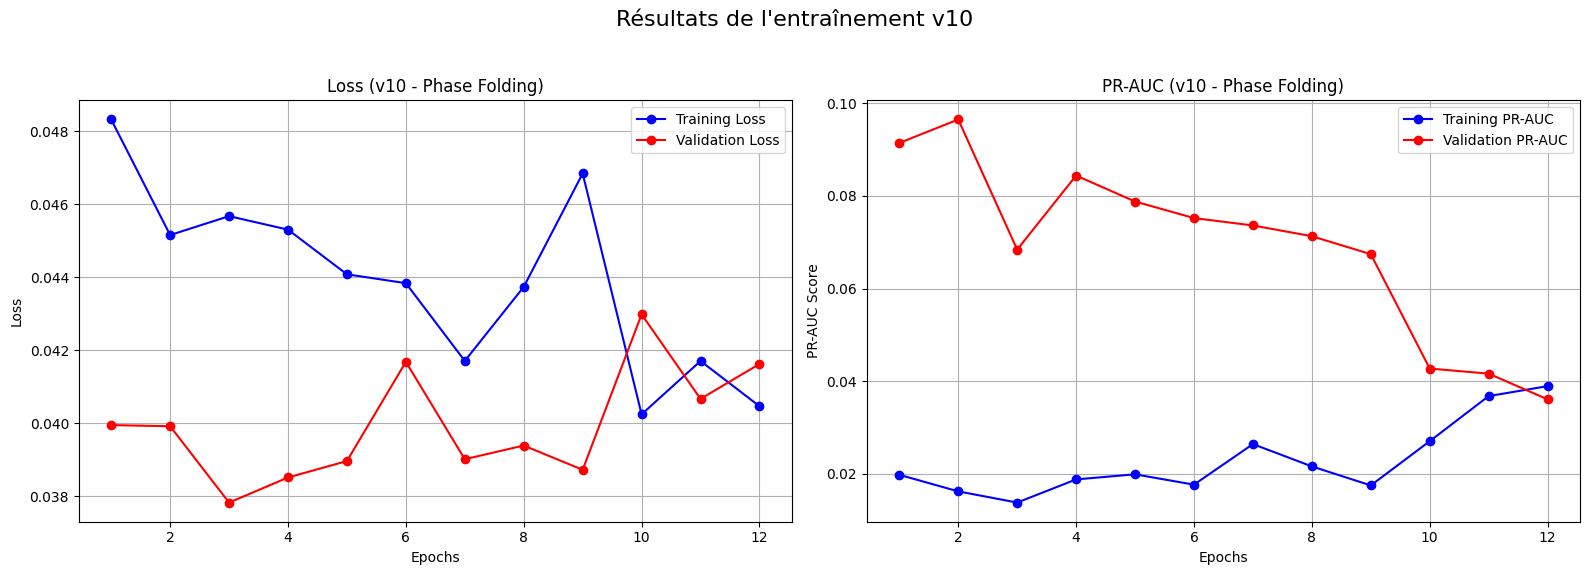

In [32]:
print("Affichage des graphiques d'entraînement (v10)...")
history_dict = history.history

# Récupérer les métriques
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']

# Créer la plage d'époques (nombre d'époques réellement exécutées)
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

# Créer la figure
plt.figure(figsize=(16, 6))

# Graphique 1 : Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss (v10 - Phase Folding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graphique 2 : PR-AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('PR-AUC (v10 - Phase Folding)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()
plt.grid(True)

plt.suptitle("Résultats de l'entraînement v10", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()